# Clustering Analysis of Cytograph's Cluster 9 & Cell Re-Annotation

In thinotebooket, I performed a clustering analysis on Cluster, previously annotated as gIPCs, 9 obtained from the Cytograph pipeline. The analysis was necessary because the UMAP visualization suggested that Cluster 9 contained cells that likely belonged to astrocytes. Upon further investigation, this assumption was confirmed.

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
from harmony import harmonize
import matplotlib as mpl
import matplotlib.pyplot as plt

#### Importing `noAdolescence_nocc_noclusters_FirstManualAnnotations.h5ad`, the anndata saved after the Step 2 in the main notebook.

In [3]:
adata = sc.read_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/noAdolescence_nocc_noclusters_FirstManualAnnotations.h5ad')

In [4]:
adata.obs.FirstManualAnnotations.value_counts()

FirstManualAnnotations
nIPCs                66389
early Radial Glia    54535
late Radial Glia     39861
Astrocytes           33900
OPCs                 20927
gIPCs                14372
Name: count, dtype: int64

#### gIPCs (cluster 9) looks like it contains astrocytic cells

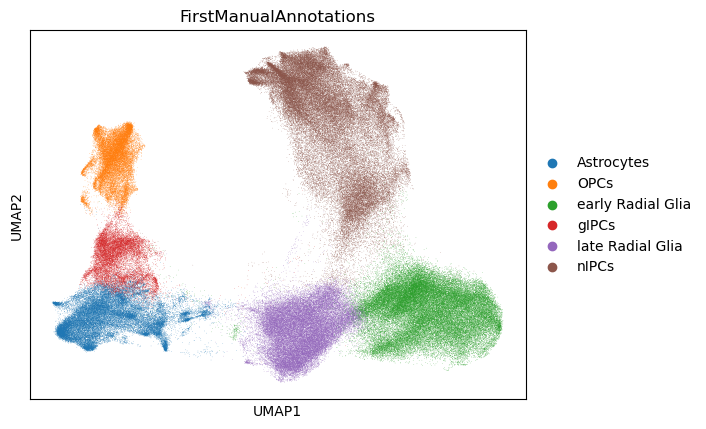

In [5]:
sc.pl.embedding(adata, basis = 'UMAP', color = 'FirstManualAnnotations')

#### Selection and visualization of cells labelled gIPCs.

In [6]:
glial = adata[adata.obs.FirstManualAnnotations == 'gIPCs']

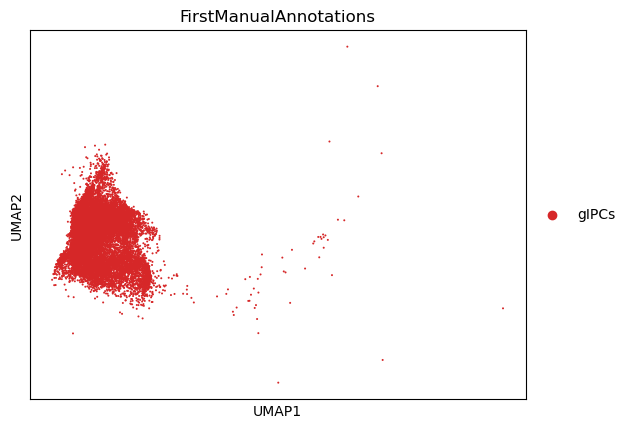

In [7]:
sc.pl.embedding(glial, basis = 'UMAP', color = 'FirstManualAnnotations')

#### To ensure the identification of cell-type-specific markers, I removed genes associated with cell cycling, mitochondrial activity, and ribosomal functions.

In [8]:
ccGenesHuman = np.loadtxt('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/models/ccGenesHuman.txt', dtype=str)
mask = ~glial.var_names.isin(ccGenesHuman)
glial = glial[:, mask]

badGenes = []
for el in glial.var_names:
    if el.startswith('MT-'):
        badGenes.append(el)
    elif el.startswith('RP'):
        badGenes.append(el)
glial = glial[:, ~glial.var_names.isin(badGenes)]

#### Before integrating the datasets, I normalized and applied a logarithmic transformation to the data. Subsequently, I identified the highly variable genes, scaled the dataset, and conducted principal component analysis.

In [9]:
sc.pp.normalize_total(glial, target_sum=1e4)
sc.pp.log1p(glial)
sc.pp.highly_variable_genes(glial, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(glial, max_value=10)
sc.tl.pca(glial, svd_solver="auto", use_highly_variable=True)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


#### Harmony integration, using a random state for reproducibility

In [10]:
glial.obsm['X_pca_harmony'] = harmonize(
    glial.obsm['X_pca'],
    glial.obs,
    'donor_kim',
    theta=1.5,                            
    max_iter_harmony=30,    
    random_state=0
)

	Initialization is completed.
	Completed 1 / 30 iteration(s).
	Completed 2 / 30 iteration(s).
	Completed 3 / 30 iteration(s).
	Completed 4 / 30 iteration(s).
	Completed 5 / 30 iteration(s).
	Completed 6 / 30 iteration(s).
	Completed 7 / 30 iteration(s).
	Completed 8 / 30 iteration(s).
	Completed 9 / 30 iteration(s).
	Completed 10 / 30 iteration(s).
	Completed 11 / 30 iteration(s).
	Completed 12 / 30 iteration(s).
Reach convergence after 12 iteration(s).


#### After processing the data, I computed the neighbors and generated a UMAP representation. I then plotted various genes on this UMAP to assess the potential presence of astrocytic cells within the dataset.
It is already apparent which area of the UMAP predominantly features astrocytic cells.

In [11]:
sc.pp.neighbors(glial, n_neighbors=25, n_pcs=50, use_rep='X_pca_harmony')
sc.tl.umap(glial)

2025-02-06 08:34:34.101857: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 08:34:47.989024: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-06 08:35:09.206322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


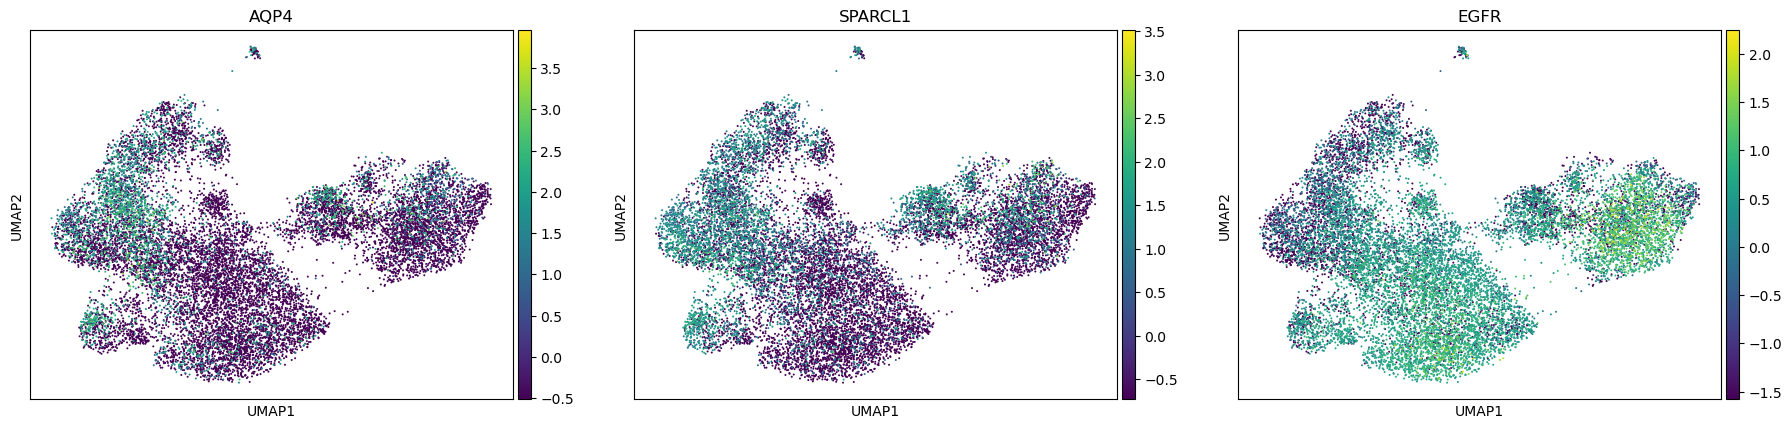

In [12]:
sc.pl.umap(glial, color=['AQP4', 'SPARCL1', 'EGFR'])

In [13]:
sc.tl.leiden(
    glial,
    resolution=0.3,
    random_state=0,
    flavor="igraph",
    n_iterations=10,
    directed=False,
)

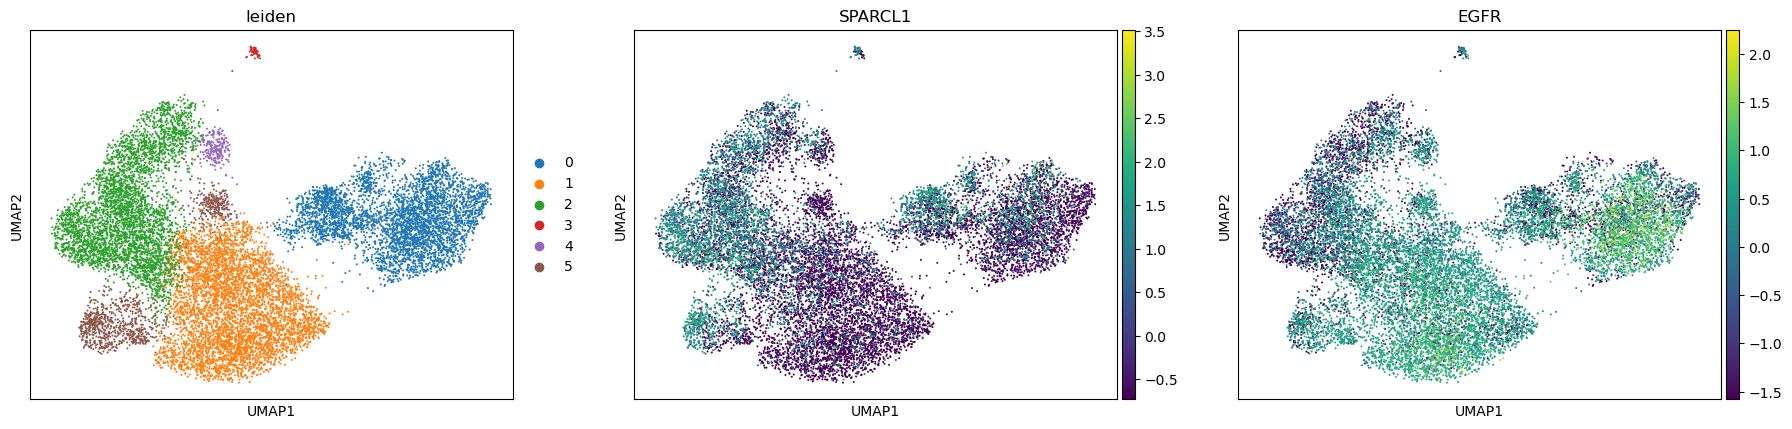

In [14]:
sc.pl.umap(glial, color=['leiden', 'SPARCL1', 'EGFR'])

#### By comparing the UMAP with cluster distributions and the expression of SPARCL1 (an astrocytic marker) and EGFR (a gIPC marker), it becomes evident that Cluster 2 is primarily astrocytic. Consequently, I have reannotated the cells in this cluster to reflect their astrocytic characteristics.

In [15]:
glial.obs['Cluster9Reannotation'] = glial.obs['leiden'].apply(lambda x: 'Astrocytes' if x == '2' else 'gIPCs')

In [16]:
glial

AnnData object with n_obs × n_vars = 14372 × 15866
    obs: 'CellClass', 'CellCycleFraction', 'DoubletFlag', 'DoubletScore', 'Region', 'Subdivision', 'Subregion', 'Tissue', 'TopLevelCluster', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'sample_id', 'cluster_id', 'NGenes', 'AnnotationAle', 'Neuroepithelial', 'TotalUMI', 'Chemistry', 'assay', 'filename', 'dataset', 'Group', 'sex', 'class', 'subclass', 'type', 'Estimated_postconceptional_age_in_days', 'nCount_RNA', 'nFeature_RNA', 'nucleosome_signal', 'TSS.enrichment', 'SCR_score', 'Clusters', 'CellCycle_G1', 'CellCycle_S', 'CellCycle_G2M', 'CellCycle', 'IsCycling', 'Neuroep_no_neuron_or_oligo', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'sample', 'region', 'PMI', 'tissue_type', 'cell_type', '

#### UMAP representation of the re-annotated cells.

In [17]:
clusters_new_palette = [  "#b75970", "#7fdc64", "#2c647e", "#b1bf81", "#c5089e", "#809776", "#ae4acd","#0064e1","#94abe1", "#7d4400", "#0cc0aa"]

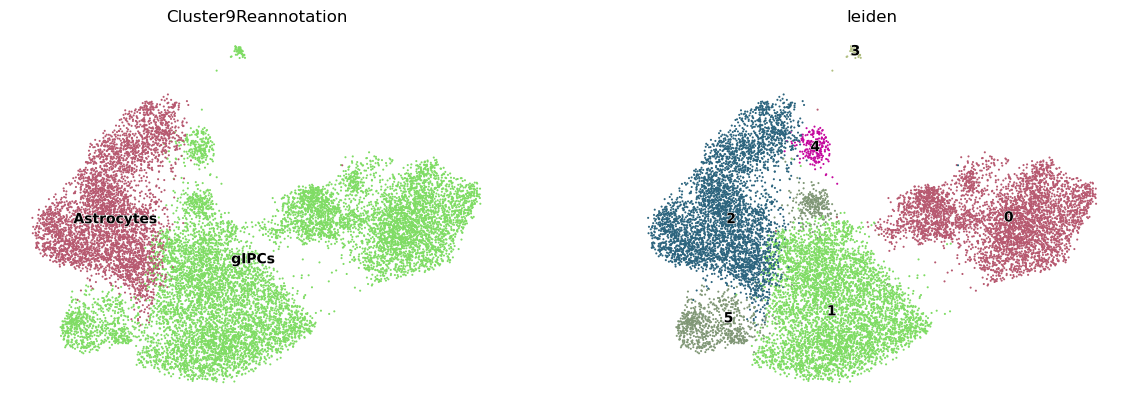

In [18]:
ax = sc.pl.embedding(
    glial,
    basis='X_umap',
    color= ['Cluster9Reannotation', 'leiden'],
    palette=clusters_new_palette,
    size=9,
    #alpha=0.8,
    legend_loc='on data',
    legend_fontsize=10,
    legend_fontoutline=0.7,
    frameon=False,
    show=False, 
    return_fig=True
)

#### save the result to import it into the main notebook `from_noAdolescence_to_final_training_dataset.ipynb`

In [19]:
#glial.obs[['Cluster9Reannotation']].to_csv('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/Cluster9Reannotation.csv')